# Multimedijske arhitekture i sustavi

## Demonstracija 1. domaće zadaće

*zadnje ažurirano 12.10.2020.*

### Zadatak

Potrebno je napisati program koji:

- učitava **.ppm** sliku
- radi konverziju **RGB** u **YCbCr**
- radi pomak domene iz $\left[ 0, 255 \right]$ u $\left[ -128, 127 \right]$
- radi 2D-DCT
- kvantizira Y komponentu s kvantizacijskom tablicom K.1
- kvantizira Cb i Cr komponente s kvantizacijskom tablicom K.2
- ispisuje u ASCII formatu kvantizirane koeficijente za proizvoljni blok
- sprema ispis koeficijenata u proizvoljnu tekstualnu datoteku

### Priprema

Prvo osiguravamo da smo pravilno pozicionirani.

In [1]:
import os

CD_KEY = "--IN_ROOT"

In [2]:
if CD_KEY not in os.environ:
    os.environ[CD_KEY] = "false"

In [3]:
if (
    CD_KEY not in os.environ
    or os.environ[CD_KEY] is None
    or len(os.environ[CD_KEY]) == 0
    or os.environ[CD_KEY] == "false"
):
    %cd ..
else:
    print(os.getcwd())
    
os.environ[CD_KEY] = "true"

/mnt/data/projekti/faks/MAIS/dz/dz-01


Onda učitavamo sve potrebne pakete.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from src.quantization.ycbcr_quantization import (
    dequantize, get_quantization_tensor, quantize,
)
from src.parsing.ppm_parsing import Ppm6Image
from src.transformations.image_transformations import (
    dct_2d,
    divide_image_to_blocks,
    idct_2d,
    merge_blocks_to_image,
    rgb_to_ycbcr,
    shift_image_pixels,
    ycbcr_to_rgb
)
from src.transformations.matrix_transformations import (
    zigzag_pixel_blocks
)

Sad možemo nastaviti na ostatak demonstracije.

### Učitavanje slike

Slika se nalazi u `data` direktoriju.

In [5]:
image_path = "data/lenna.ppm"

Možemo je učitati predajom puta do slike u **Ppm6Image** konstruktor.

In [6]:
image = Ppm6Image(image_path)

Sad možemo vidjeti i kako izgleda ova slika.

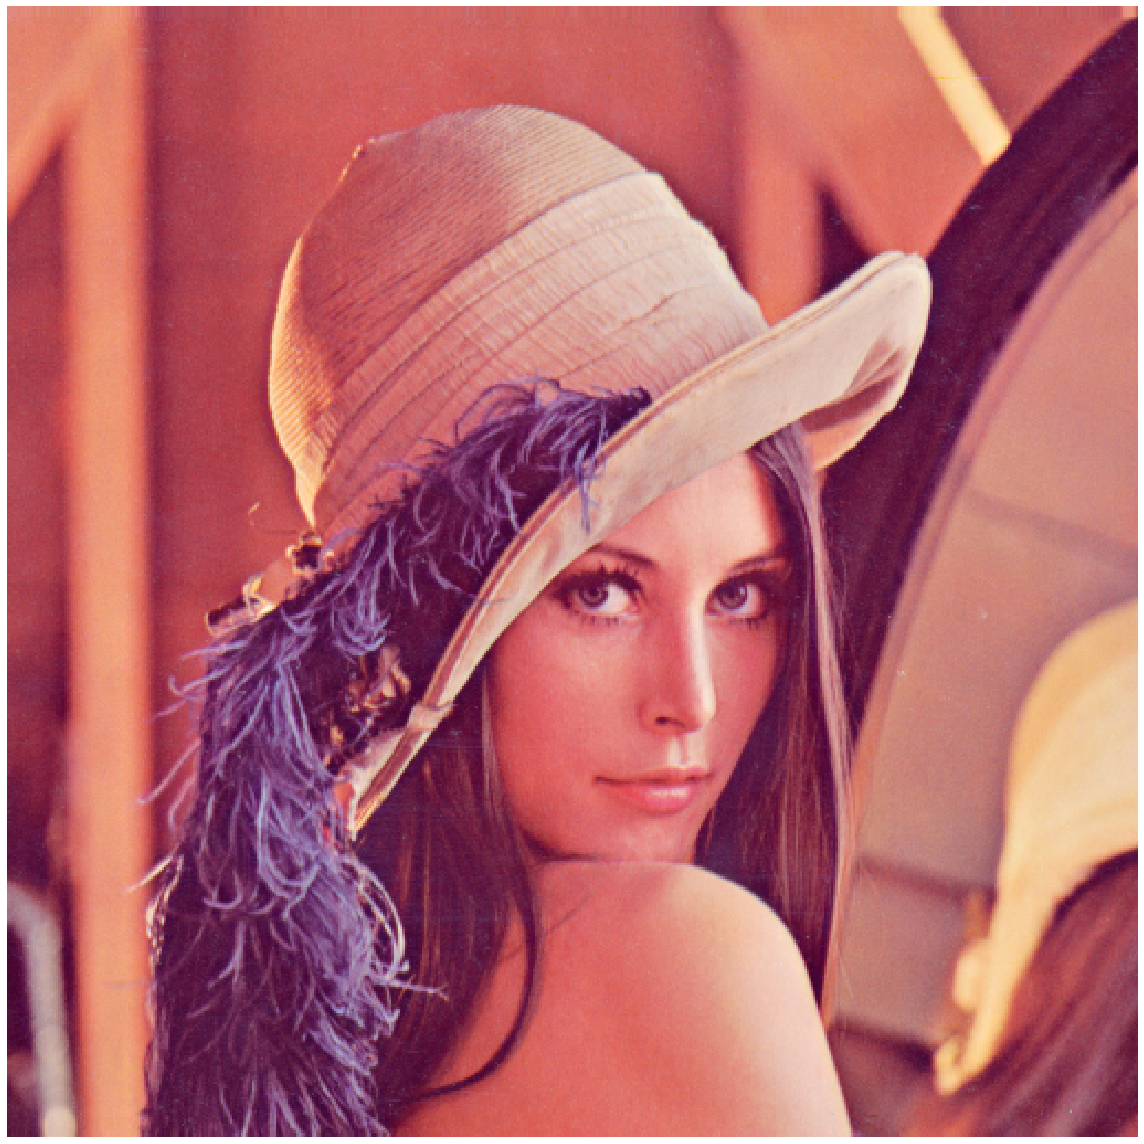

In [7]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(image.data)
plt.axis("off");
fig.tight_layout()

### Konverzija RGB u YCbCr

Trenutno je naša slika u RGB formatu:

In [8]:
print(image.data)

[[[226 137 125]
  [226 137 125]
  [223 137 133]
  ...
  [230 148 122]
  [221 130 110]
  [200  99  90]]

 [[226 137 125]
  [226 137 125]
  [223 137 133]
  ...
  [230 148 122]
  [221 130 110]
  [200  99  90]]

 [[226 137 125]
  [226 137 125]
  [223 137 133]
  ...
  [230 148 122]
  [221 130 110]
  [200  99  90]]

 ...

 [[ 84  18  60]
  [ 84  18  60]
  [ 92  27  58]
  ...
  [173  73  84]
  [172  68  76]
  [177  62  79]]

 [[ 82  22  57]
  [ 82  22  57]
  [ 96  32  62]
  ...
  [179  70  79]
  [181  71  81]
  [185  74  81]]

 [[ 82  22  57]
  [ 82  22  57]
  [ 96  32  62]
  ...
  [179  70  79]
  [181  71  81]
  [185  74  81]]]


Trebamo je pretvoriti u **YCbCr** format. To ćemo učiniti koristeći pomoćnu funkciju.

In [9]:
image_ycbcr = rgb_to_ycbcr(image.data)

Sada imamo ovakav zapis

In [10]:
print(image_ycbcr)

[[[162.243  106.9857 173.4756]
  [162.243  106.9857 173.4756]
  [162.258  111.4918 171.3252]
  ...
  [169.554  101.1666 171.1138]
  [154.929  102.6483 175.126 ]
  [128.173  106.4613 179.2317]]

 [[162.243  106.9857 173.4756]
  [162.243  106.9857 173.4756]
  [162.258  111.4918 171.3252]
  ...
  [169.554  101.1666 171.1138]
  [154.929  102.6483 175.126 ]
  [128.173  106.4613 179.2317]]

 [[162.243  106.9857 173.4756]
  [162.243  106.9857 173.4756]
  [162.258  111.4918 171.3252]
  ...
  [169.554  101.1666 171.1138]
  [154.929  102.6483 175.126 ]
  [128.173  106.4613 179.2317]]

 ...

 [[ 42.522  137.8658 157.5854]
  [ 42.522  137.8658 157.5854]
  [ 49.969  132.5345 157.9797]
  ...
  [104.154  116.63   177.1057]
  [100.008  114.4552 179.3496]
  [ 98.323  117.0995 184.1179]]

 [[ 43.93   135.378  155.1545]
  [ 43.93   135.378  155.1545]
  [ 54.556  132.2032 157.561 ]
  ...
  [103.617  114.1117 181.7683]
  [105.03   114.443  182.187 ]
  [107.987  112.7743 182.9309]]

 [[ 43.93   135.378  155

### Pomak domene

Kako kosinusna transformacija koristi i negativne brojeve, prvo bi bilo dobro pretvoriti našu struktno pozitivno domenu u $\left[ -128, 127 \right]$.

In [11]:
shifted_ycbcr = shift_image_pixels(image_ycbcr, -128)

Sad naša reprezentacija izgleda ovako

In [12]:
print(shifted_ycbcr)

[[[ 34.243  -21.0143  45.4756]
  [ 34.243  -21.0143  45.4756]
  [ 34.258  -16.5082  43.3252]
  ...
  [ 41.554  -26.8334  43.1138]
  [ 26.929  -25.3517  47.126 ]
  [  0.173  -21.5387  51.2317]]

 [[ 34.243  -21.0143  45.4756]
  [ 34.243  -21.0143  45.4756]
  [ 34.258  -16.5082  43.3252]
  ...
  [ 41.554  -26.8334  43.1138]
  [ 26.929  -25.3517  47.126 ]
  [  0.173  -21.5387  51.2317]]

 [[ 34.243  -21.0143  45.4756]
  [ 34.243  -21.0143  45.4756]
  [ 34.258  -16.5082  43.3252]
  ...
  [ 41.554  -26.8334  43.1138]
  [ 26.929  -25.3517  47.126 ]
  [  0.173  -21.5387  51.2317]]

 ...

 [[-85.478    9.8658  29.5854]
  [-85.478    9.8658  29.5854]
  [-78.031    4.5345  29.9797]
  ...
  [-23.846  -11.37    49.1057]
  [-27.992  -13.5448  51.3496]
  [-29.677  -10.9005  56.1179]]

 [[-84.07     7.378   27.1545]
  [-84.07     7.378   27.1545]
  [-73.444    4.2032  29.561 ]
  ...
  [-24.383  -13.8883  53.7683]
  [-22.97   -13.557   54.187 ]
  [-20.013  -15.2257  54.9309]]

 [[-84.07     7.378   27

### 2D-DCT

Nad pomaknutom reprezentacijom trebamo obaviti 8x8 2D-DCT. Prvo bi bilo dobro da podijelimo sliku na $8 \times 8$ blokove.

In [13]:
pixel_blocks = divide_image_to_blocks(shifted_ycbcr)

Inicijalno je oblik podataka bio ovo

In [14]:
print(shifted_ycbcr.shape)

(512, 512, 3)


Sada je ovo

In [15]:
print(pixel_blocks.shape)

(64, 64, 8, 8, 3)


Vidimo da ono što smo dobili je $64 \times 64$ mozaik $8 \times 8$ blokova. Nad svakim od ovih blokova radimo dvodimenzionalnu diskretnu kosinusnu transformaciju:

In [16]:
dct_blocks = dct_2d(pixel_blocks, verbose=1)

100%|██████████| 4096/4096 [02:12<00:00, 30.91it/s]


Možemo vidjeti da se sad oblik naših podataka nije promijenio

In [17]:
print(dct_blocks.shape)

(64, 64, 8, 8, 3)


A prvi blok, npr., izgleda ovako

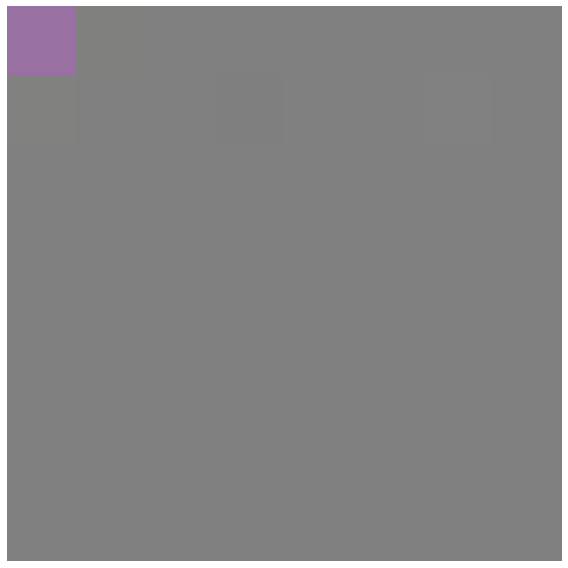

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.rint(dct_blocks[0][0] / 11 + 128).astype(int))
plt.axis("off");
fig.tight_layout()

Razlog za ovo reskaliranje `dct_blocks` je da dobijemo sliku gdje su vrijednosti unutar nekih normalnih za sliku - u suprotnom imamo preveliku domenu. Razlog zašto su više frekvencije sive su zato što je njihova energija bila gotovo $0$, pa operacijama kojima smo transformirali DCT blok smo ih postavili na odmak, $128$, što je siva boja u RGB-u.

### Kvantizacija

Sad ćemo kvantizirati naše blokove. Sve što radimo je, zapravo, dijeljenje s $8 \times 8$ tablicama i zaokružujemo rezultat na cijeli broj. Prvo ćemo izgenerirati kvantizacijsku tablicu - $8 \times 8 \times 3$ tenzor s kojim ćemo dijeliti svaki blok.

In [19]:
quantization_tensor = get_quantization_tensor()

Zatim možemo primijeniti kvantizaciju na naše DCT-ane blokove.

In [20]:
quantized_blocks = quantize(dct_blocks, quantization_tensor)

Prvi blok ove reprezentacije izgleda ovako

In [21]:
print(quantized_blocks[0][0].transpose(2, 0, 1))

[[[ 16   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]]

 [[-10   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]]

 [[ 22   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0]]]


Ono što možemo je pretvoriti proizvoljan blok u zig-zag poredak, čime ćemo pseudosortirati elemenete matrice silazno po apriornoj vjerojatnosti visoke energije. Za ovaj isti blok, dobit ćemo sljedeće

In [22]:
zigzagged_blocks = zigzag_pixel_blocks(quantized_blocks)

In [23]:
print(zigzagged_blocks[0][0])

[[ 16   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [-10   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [ 22   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]]


### Reverzija

Kako bi provjerili da cijeli postupak radi, sad ćemo ga obrnuti i vidjeti možemo li dobiti istu ili barem sličnu sliku. Osim kvantizacije nećemo maskirati visoke frekvencije jer bi već kvantizacijom trebali izgubiti dovoljno podataka.

#### Dekvantizacija

In [24]:
dequantized_blocks = dequantize(quantized_blocks, quantization_tensor)

#### Inverzni 2D DCT

In [25]:
idct_blocks = idct_2d(dequantized_blocks, verbose=1)

100%|██████████| 4096/4096 [03:29<00:00, 19.53it/s]


#### Spajanje blokova

In [26]:
merged_blocks = merge_blocks_to_image(idct_blocks)

#### Vraćanje stare domene

In [27]:
shifted_merged_blocks = shift_image_pixels(merged_blocks, 128)

#### Vraćanje iz YCbCr u RGB

In [28]:
restored_image = ycbcr_to_rgb(shifted_merged_blocks)

Kao dodatan korak, moramo osigurati da su nam pikseli iz dobrog ranga, tj. moramo podrezati piksele koji su pobjegli iz $\left[0, 255 \right]$ domene. Prije tog koraka ćemo vrijednosti zaokružiti na cijele brojeve, a nakon toga pretvoriti ih u cijele brojeva u smislu podatkovnog tipa.

In [29]:
rounded_image = np.rint(restored_image)

In [30]:
clipped_image = np.clip(rounded_image, 0, 255)

In [31]:
final_image = clipped_image.astype(int)

Sada tu sliku možemo i prikazati.

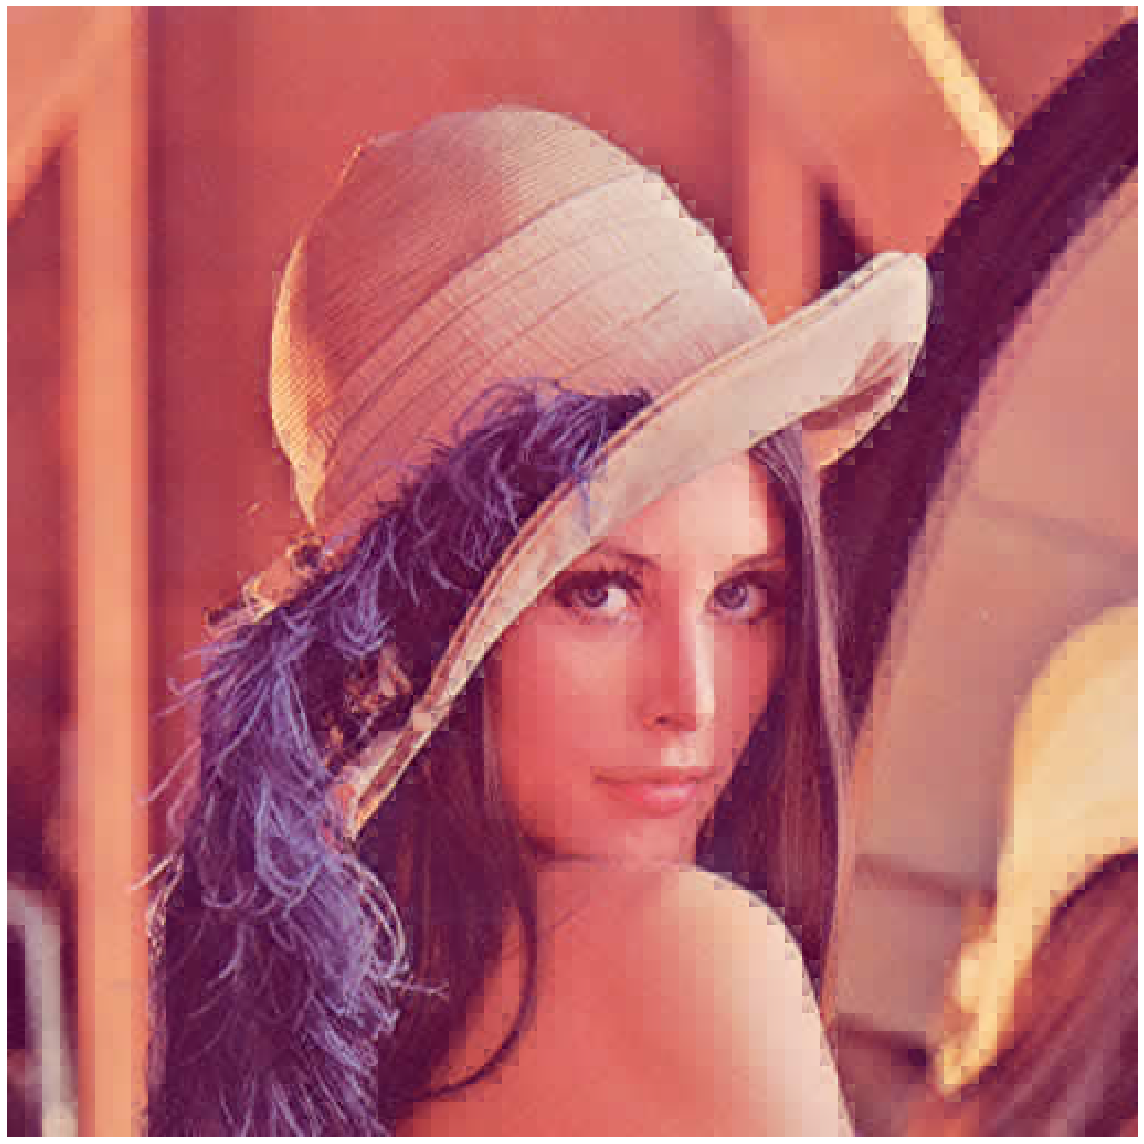

In [32]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(final_image)
plt.axis("off");
fig.tight_layout()

Vidimo da nam je kompresija i dekompresija uspjela, ali slika je praktički uništena.

### Završne riječi

Ova bilježnica je samo primjer korištenja funkcionalnosti - ona **nije** rješenje ove domaće zadaće (iako bi trebala biti, a ne debilan način s monolitskom datotekom). Za to provirite u `solution` direktorij.